# Waveform Analysis Exploration 

Need a function for mass data addition (all the unique EDF files). I'll merge them into a single table for easy analysis. Waves are waves-- so long as they have the same filtering and they're all originally raw EEG! 

Since there's a major problem with unreliable annotations, I'm taking matters into my own hands and manually constructing a label list for fixed 30s intervals. I'll do this by binning annotations from the paired Hypnogram for each file. 
- Going to time-align the labels using `raw.annotations` 
- Then slice the entire sleep period into 30s chunks 
- Finally, assign the sleep stage based on the label-list 

In [2]:
import numpy as np
import pandas as pd
import mne 
from mne.time_frequency import psd_array_welch
import matplotlib.pyplot as plt
import os

def process_edf_pair(psg_path, hypnogram_path): 
    '''
    Loads EDF EEG recording and corresponding hypnogram 
    Extracts 30s epochs, labels them, and returns a features df

    Returns: 
        features (pd.DataFrame): Features + newly created 'label' col (sleep stage as str)
    '''

    raw = mne.io.read_raw_edf(psg_path, preload=True) 
    raw.set_annotations(mne.read_annotations(hypnogram_path))
    raw.pick(['EEG Fpz-Cz']) 

    data = raw.get_data()[0]
    sfreq = raw.info['sfreq']
    total_duration = int(data.shape[-1] / sfreq) # in seconds!

    # Map annotation label -> clean stage name
    stage_map = {
        'Sleep stage W': 'Wake',
        'Sleep stage 1': 'N1',
        'Sleep stage 2': 'N2',
        'Sleep stage 3': 'N3',
        'Sleep stage 4': 'N3', # Mergnig 4 into N3
        'Sleep stage R': 'REM'
    }

    epoch_length = 30 # seconds
    n_epochs = total_duration // epoch_length
    labels = ['UNKNOWN'] * n_epochs

    for ann in raw.annotations:
        label = stage_map.get(ann['description'], None)
        if label is None: 
            continue
        start = int(ann['onset']) // epoch_length
        duration = int(ann['duration']) // epoch_length

        for i in range(start, min(start + duration, n_epochs)):
            labels[i] = label

    # Remove unknown-labeled epochs
    valid_idxs = [i for i, l in enumerate(labels) if l != 'UNKNOWN'] 

    # Manually epoch the signal into 30s chunks 
    samples_per_epoch = int(epoch_length * sfreq) 
    epoch_data = np.array([
        data[i * samples_per_epoch:(i+1) * samples_per_epoch]
        for i in valid_idxs if (i+1) * samples_per_epoch <= len(data) 
    ])
        
    # Compute bandpower features 
    psds, freqs = psd_array_welch(epoch_data[:, np.newaxis, :], sfreq=sfreq, fmin=0.5, fmax=40, n_fft=256)

    features = pd.DataFrame({
        'delta': bandpower(psds, freqs, (0.5, 4)),
        'theta': bandpower(psds, freqs, (4, 8)),
        'alpha': bandpower(psds, freqs, (8, 13)),
        'beta':  bandpower(psds, freqs, (13, 30)),
        'label': [labels[i] for i in valid_idxs]
    })

    # Adding subject ID derived from filename (ex. "ST7011J") 
    subj_id = os.path.basename(psg_path)[2:6]
    features['subject_id'] = subj_id

    return features

def bandpower(psds, freqs, band):
    '''
    Small hepler for process_edf_pair
    Returns mean band power in specified frequency band
    '''
    idx = (freqs >= band[0]) & (freqs <= band[1])
    return psds[:, :, idx].mean(axis=-1).mean(axis=1)



### Now Loop over all .edf files!

In [3]:
import os

# Match PSG and Hypnogram files by prefix
data_dir = '../data/sleep_waves/'
files = os.listdir(data_dir) 

# Grouping PSG and Hypnogram files by shared sybject root (first 7 chars) 
psg_files = [f for f in files if f.endswith('-PSG.edf')]
hyp_files = [f for f in files if 'Hypnogram' in f] 

file_pairs = []

for psg in psg_files:
    subj_root = psg[:7] # example: 'ST7011J'
    matching_hyp = [h for h in hyp_files if h.startswith(subj_root)]

    if matching_hyp: 
        psg_path = os.path.join(data_dir, psg) 
        hyp_path = os.path.join(data_dir, matching_hyp[0]) # Note: assuming only 1 match! 
        file_pairs.append((psg_path, hyp_path)) 
    else: 
        print(f'No matching hypnogram for {psg}')

print(f'Found {len(file_pairs)} valid PSG-Hypnogram edf pairs') 

# Process all and concat 
all_feats = []

for psg, hyp in file_pairs:
    print(f"🧪 Processing: {os.path.basename(psg)} & {os.path.basename(hyp)}")
    try: 
        features = process_edf_pair(psg, hyp)
        all_feats.append(features) 
        print(f'\n✅ Processed: {os.path.basename(psg)}:{len(features)} epochs\n')
    except Exception as e: 
        print(f'❌ Failed on {psg}: {e}')

df_edf = pd.concat(all_feats, ignore_index=True) 




Found 44 valid PSG-Hypnogram edf pairs
🧪 Processing: ST7011J0-PSG.edf & ST7011JP-Hypnogram.edf
Extracting EDF parameters from c:\Users\andre\OneDrive\Desktop\Code_Projects\DS_Tutorials\data\sleep_waves\ST7011J0-PSG.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 3589999  =      0.000 ... 35899.990 secs...


C:\Users\andre\AppData\Local\Temp\ipykernel_8408\760237435.py:17: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(psg_path, preload=True)
C:\Users\andre\AppData\Local\Temp\ipykernel_8408\760237435.py:17: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(psg_path, preload=True)


Effective window size : 2.560 (s)

✅ Processed: ST7011J0-PSG.edf:1092 epochs

🧪 Processing: ST7012J0-PSG.edf & ST7012JP-Hypnogram.edf
Extracting EDF parameters from c:\Users\andre\OneDrive\Desktop\Code_Projects\DS_Tutorials\data\sleep_waves\ST7012J0-PSG.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 3131999  =      0.000 ... 31319.990 secs...


C:\Users\andre\AppData\Local\Temp\ipykernel_8408\760237435.py:17: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(psg_path, preload=True)
C:\Users\andre\AppData\Local\Temp\ipykernel_8408\760237435.py:17: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(psg_path, preload=True)


Effective window size : 2.560 (s)

✅ Processed: ST7012J0-PSG.edf:1040 epochs

🧪 Processing: ST7021J0-PSG.edf & ST7021JM-Hypnogram.edf
Extracting EDF parameters from c:\Users\andre\OneDrive\Desktop\Code_Projects\DS_Tutorials\data\sleep_waves\ST7021J0-PSG.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 3059999  =      0.000 ... 30599.990 secs...


C:\Users\andre\AppData\Local\Temp\ipykernel_8408\760237435.py:17: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(psg_path, preload=True)
C:\Users\andre\AppData\Local\Temp\ipykernel_8408\760237435.py:17: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(psg_path, preload=True)


Effective window size : 2.560 (s)

✅ Processed: ST7021J0-PSG.edf:920 epochs

🧪 Processing: ST7022J0-PSG.edf & ST7022JM-Hypnogram.edf
Extracting EDF parameters from c:\Users\andre\OneDrive\Desktop\Code_Projects\DS_Tutorials\data\sleep_waves\ST7022J0-PSG.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 3075999  =      0.000 ... 30759.990 secs...


C:\Users\andre\AppData\Local\Temp\ipykernel_8408\760237435.py:17: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(psg_path, preload=True)
C:\Users\andre\AppData\Local\Temp\ipykernel_8408\760237435.py:17: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(psg_path, preload=True)


Effective window size : 2.560 (s)

✅ Processed: ST7022J0-PSG.edf:944 epochs

🧪 Processing: ST7041J0-PSG.edf & ST7041JO-Hypnogram.edf
Extracting EDF parameters from c:\Users\andre\OneDrive\Desktop\Code_Projects\DS_Tutorials\data\sleep_waves\ST7041J0-PSG.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 3115999  =      0.000 ... 31159.990 secs...


C:\Users\andre\AppData\Local\Temp\ipykernel_8408\760237435.py:17: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(psg_path, preload=True)
C:\Users\andre\AppData\Local\Temp\ipykernel_8408\760237435.py:17: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(psg_path, preload=True)


Effective window size : 2.560 (s)

✅ Processed: ST7041J0-PSG.edf:1007 epochs

🧪 Processing: ST7042J0-PSG.edf & ST7042JO-Hypnogram.edf
Extracting EDF parameters from c:\Users\andre\OneDrive\Desktop\Code_Projects\DS_Tutorials\data\sleep_waves\ST7042J0-PSG.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 3470999  =      0.000 ... 34709.990 secs...


C:\Users\andre\AppData\Local\Temp\ipykernel_8408\760237435.py:17: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(psg_path, preload=True)
C:\Users\andre\AppData\Local\Temp\ipykernel_8408\760237435.py:17: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(psg_path, preload=True)


Effective window size : 2.560 (s)

✅ Processed: ST7042J0-PSG.edf:1130 epochs

🧪 Processing: ST7051J0-PSG.edf & ST7051JA-Hypnogram.edf
Extracting EDF parameters from c:\Users\andre\OneDrive\Desktop\Code_Projects\DS_Tutorials\data\sleep_waves\ST7051J0-PSG.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 3219999  =      0.000 ... 32199.990 secs...


C:\Users\andre\AppData\Local\Temp\ipykernel_8408\760237435.py:17: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(psg_path, preload=True)
C:\Users\andre\AppData\Local\Temp\ipykernel_8408\760237435.py:17: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(psg_path, preload=True)


Effective window size : 2.560 (s)

✅ Processed: ST7051J0-PSG.edf:1018 epochs

🧪 Processing: ST7052J0-PSG.edf & ST7052JA-Hypnogram.edf
Extracting EDF parameters from c:\Users\andre\OneDrive\Desktop\Code_Projects\DS_Tutorials\data\sleep_waves\ST7052J0-PSG.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 3282999  =      0.000 ... 32829.990 secs...


C:\Users\andre\AppData\Local\Temp\ipykernel_8408\760237435.py:17: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(psg_path, preload=True)
C:\Users\andre\AppData\Local\Temp\ipykernel_8408\760237435.py:17: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(psg_path, preload=True)


Effective window size : 2.560 (s)

✅ Processed: ST7052J0-PSG.edf:1034 epochs

🧪 Processing: ST7061J0-PSG.edf & ST7061JR-Hypnogram.edf
Extracting EDF parameters from c:\Users\andre\OneDrive\Desktop\Code_Projects\DS_Tutorials\data\sleep_waves\ST7061J0-PSG.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 3256999  =      0.000 ... 32569.990 secs...


C:\Users\andre\AppData\Local\Temp\ipykernel_8408\760237435.py:17: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(psg_path, preload=True)
C:\Users\andre\AppData\Local\Temp\ipykernel_8408\760237435.py:17: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(psg_path, preload=True)


Effective window size : 2.560 (s)

✅ Processed: ST7061J0-PSG.edf:1008 epochs

🧪 Processing: ST7062J0-PSG.edf & ST7062JR-Hypnogram.edf
Extracting EDF parameters from c:\Users\andre\OneDrive\Desktop\Code_Projects\DS_Tutorials\data\sleep_waves\ST7062J0-PSG.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 3277999  =      0.000 ... 32779.990 secs...


C:\Users\andre\AppData\Local\Temp\ipykernel_8408\760237435.py:17: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(psg_path, preload=True)
C:\Users\andre\AppData\Local\Temp\ipykernel_8408\760237435.py:17: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(psg_path, preload=True)


Effective window size : 2.560 (s)

✅ Processed: ST7062J0-PSG.edf:952 epochs

🧪 Processing: ST7071J0-PSG.edf & ST7071JA-Hypnogram.edf
Extracting EDF parameters from c:\Users\andre\OneDrive\Desktop\Code_Projects\DS_Tutorials\data\sleep_waves\ST7071J0-PSG.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 2745999  =      0.000 ... 27459.990 secs...


C:\Users\andre\AppData\Local\Temp\ipykernel_8408\760237435.py:17: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(psg_path, preload=True)
C:\Users\andre\AppData\Local\Temp\ipykernel_8408\760237435.py:17: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(psg_path, preload=True)


Effective window size : 2.560 (s)

✅ Processed: ST7071J0-PSG.edf:821 epochs

🧪 Processing: ST7072J0-PSG.edf & ST7072JA-Hypnogram.edf
Extracting EDF parameters from c:\Users\andre\OneDrive\Desktop\Code_Projects\DS_Tutorials\data\sleep_waves\ST7072J0-PSG.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 2745999  =      0.000 ... 27459.990 secs...


C:\Users\andre\AppData\Local\Temp\ipykernel_8408\760237435.py:17: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(psg_path, preload=True)
C:\Users\andre\AppData\Local\Temp\ipykernel_8408\760237435.py:17: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(psg_path, preload=True)


Effective window size : 2.560 (s)

✅ Processed: ST7072J0-PSG.edf:914 epochs

🧪 Processing: ST7081J0-PSG.edf & ST7081JW-Hypnogram.edf
Extracting EDF parameters from c:\Users\andre\OneDrive\Desktop\Code_Projects\DS_Tutorials\data\sleep_waves\ST7081J0-PSG.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 2899999  =      0.000 ... 28999.990 secs...


C:\Users\andre\AppData\Local\Temp\ipykernel_8408\760237435.py:18: RuntimeWarning: Limited 1 annotation(s) that were expanding outside the data range.
  raw.set_annotations(mne.read_annotations(hypnogram_path))
C:\Users\andre\AppData\Local\Temp\ipykernel_8408\760237435.py:17: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(psg_path, preload=True)
C:\Users\andre\AppData\Local\Temp\ipykernel_8408\760237435.py:17: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(psg_path, preload=True)


Effective window size : 2.560 (s)

✅ Processed: ST7081J0-PSG.edf:966 epochs

🧪 Processing: ST7082J0-PSG.edf & ST7082JW-Hypnogram.edf
Extracting EDF parameters from c:\Users\andre\OneDrive\Desktop\Code_Projects\DS_Tutorials\data\sleep_waves\ST7082J0-PSG.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 2852999  =      0.000 ... 28529.990 secs...


C:\Users\andre\AppData\Local\Temp\ipykernel_8408\760237435.py:18: RuntimeWarning: Limited 1 annotation(s) that were expanding outside the data range.
  raw.set_annotations(mne.read_annotations(hypnogram_path))
C:\Users\andre\AppData\Local\Temp\ipykernel_8408\760237435.py:17: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(psg_path, preload=True)
C:\Users\andre\AppData\Local\Temp\ipykernel_8408\760237435.py:17: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(psg_path, preload=True)


Effective window size : 2.560 (s)

✅ Processed: ST7082J0-PSG.edf:931 epochs

🧪 Processing: ST7091J0-PSG.edf & ST7091JE-Hypnogram.edf
Extracting EDF parameters from c:\Users\andre\OneDrive\Desktop\Code_Projects\DS_Tutorials\data\sleep_waves\ST7091J0-PSG.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 2985999  =      0.000 ... 29859.990 secs...


C:\Users\andre\AppData\Local\Temp\ipykernel_8408\760237435.py:17: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(psg_path, preload=True)
C:\Users\andre\AppData\Local\Temp\ipykernel_8408\760237435.py:17: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(psg_path, preload=True)


Effective window size : 2.560 (s)

✅ Processed: ST7091J0-PSG.edf:943 epochs

🧪 Processing: ST7092J0-PSG.edf & ST7092JE-Hypnogram.edf
Extracting EDF parameters from c:\Users\andre\OneDrive\Desktop\Code_Projects\DS_Tutorials\data\sleep_waves\ST7092J0-PSG.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 2886999  =      0.000 ... 28869.990 secs...


C:\Users\andre\AppData\Local\Temp\ipykernel_8408\760237435.py:17: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(psg_path, preload=True)
C:\Users\andre\AppData\Local\Temp\ipykernel_8408\760237435.py:17: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(psg_path, preload=True)


Effective window size : 2.560 (s)

✅ Processed: ST7092J0-PSG.edf:923 epochs

🧪 Processing: ST7101J0-PSG.edf & ST7101JE-Hypnogram.edf
Extracting EDF parameters from c:\Users\andre\OneDrive\Desktop\Code_Projects\DS_Tutorials\data\sleep_waves\ST7101J0-PSG.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 3295999  =      0.000 ... 32959.990 secs...


C:\Users\andre\AppData\Local\Temp\ipykernel_8408\760237435.py:17: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(psg_path, preload=True)
C:\Users\andre\AppData\Local\Temp\ipykernel_8408\760237435.py:17: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(psg_path, preload=True)


Effective window size : 2.560 (s)

✅ Processed: ST7101J0-PSG.edf:1042 epochs

🧪 Processing: ST7102J0-PSG.edf & ST7102JE-Hypnogram.edf
Extracting EDF parameters from c:\Users\andre\OneDrive\Desktop\Code_Projects\DS_Tutorials\data\sleep_waves\ST7102J0-PSG.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 2981999  =      0.000 ... 29819.990 secs...


C:\Users\andre\AppData\Local\Temp\ipykernel_8408\760237435.py:17: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(psg_path, preload=True)
C:\Users\andre\AppData\Local\Temp\ipykernel_8408\760237435.py:17: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(psg_path, preload=True)


Effective window size : 2.560 (s)

✅ Processed: ST7102J0-PSG.edf:980 epochs

🧪 Processing: ST7111J0-PSG.edf & ST7111JE-Hypnogram.edf
Extracting EDF parameters from c:\Users\andre\OneDrive\Desktop\Code_Projects\DS_Tutorials\data\sleep_waves\ST7111J0-PSG.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 3139999  =      0.000 ... 31399.990 secs...


C:\Users\andre\AppData\Local\Temp\ipykernel_8408\760237435.py:17: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(psg_path, preload=True)
C:\Users\andre\AppData\Local\Temp\ipykernel_8408\760237435.py:17: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(psg_path, preload=True)


Effective window size : 2.560 (s)

✅ Processed: ST7111J0-PSG.edf:1017 epochs

🧪 Processing: ST7112J0-PSG.edf & ST7112JE-Hypnogram.edf
Extracting EDF parameters from c:\Users\andre\OneDrive\Desktop\Code_Projects\DS_Tutorials\data\sleep_waves\ST7112J0-PSG.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 3066999  =      0.000 ... 30669.990 secs...


C:\Users\andre\AppData\Local\Temp\ipykernel_8408\760237435.py:17: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(psg_path, preload=True)
C:\Users\andre\AppData\Local\Temp\ipykernel_8408\760237435.py:17: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(psg_path, preload=True)


Effective window size : 2.560 (s)

✅ Processed: ST7112J0-PSG.edf:978 epochs

🧪 Processing: ST7121J0-PSG.edf & ST7121JE-Hypnogram.edf
Extracting EDF parameters from c:\Users\andre\OneDrive\Desktop\Code_Projects\DS_Tutorials\data\sleep_waves\ST7121J0-PSG.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 3119999  =      0.000 ... 31199.990 secs...


C:\Users\andre\AppData\Local\Temp\ipykernel_8408\760237435.py:17: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(psg_path, preload=True)
C:\Users\andre\AppData\Local\Temp\ipykernel_8408\760237435.py:17: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(psg_path, preload=True)


Effective window size : 2.560 (s)

✅ Processed: ST7121J0-PSG.edf:1026 epochs

🧪 Processing: ST7122J0-PSG.edf & ST7122JE-Hypnogram.edf
Extracting EDF parameters from c:\Users\andre\OneDrive\Desktop\Code_Projects\DS_Tutorials\data\sleep_waves\ST7122J0-PSG.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 3034999  =      0.000 ... 30349.990 secs...


C:\Users\andre\AppData\Local\Temp\ipykernel_8408\760237435.py:17: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(psg_path, preload=True)
C:\Users\andre\AppData\Local\Temp\ipykernel_8408\760237435.py:17: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(psg_path, preload=True)


Effective window size : 2.560 (s)

✅ Processed: ST7122J0-PSG.edf:945 epochs

🧪 Processing: ST7131J0-PSG.edf & ST7131JR-Hypnogram.edf
Extracting EDF parameters from c:\Users\andre\OneDrive\Desktop\Code_Projects\DS_Tutorials\data\sleep_waves\ST7131J0-PSG.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 2765999  =      0.000 ... 27659.990 secs...


C:\Users\andre\AppData\Local\Temp\ipykernel_8408\760237435.py:17: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(psg_path, preload=True)
C:\Users\andre\AppData\Local\Temp\ipykernel_8408\760237435.py:17: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(psg_path, preload=True)


Effective window size : 2.560 (s)

✅ Processed: ST7131J0-PSG.edf:859 epochs

🧪 Processing: ST7132J0-PSG.edf & ST7132JR-Hypnogram.edf
Extracting EDF parameters from c:\Users\andre\OneDrive\Desktop\Code_Projects\DS_Tutorials\data\sleep_waves\ST7132J0-PSG.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 2697999  =      0.000 ... 26979.990 secs...


C:\Users\andre\AppData\Local\Temp\ipykernel_8408\760237435.py:17: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(psg_path, preload=True)
C:\Users\andre\AppData\Local\Temp\ipykernel_8408\760237435.py:17: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(psg_path, preload=True)


Effective window size : 2.560 (s)

✅ Processed: ST7132J0-PSG.edf:852 epochs

🧪 Processing: ST7141J0-PSG.edf & ST7141JE-Hypnogram.edf
Extracting EDF parameters from c:\Users\andre\OneDrive\Desktop\Code_Projects\DS_Tutorials\data\sleep_waves\ST7141J0-PSG.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 2760999  =      0.000 ... 27609.990 secs...


C:\Users\andre\AppData\Local\Temp\ipykernel_8408\760237435.py:17: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(psg_path, preload=True)
C:\Users\andre\AppData\Local\Temp\ipykernel_8408\760237435.py:17: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(psg_path, preload=True)


Effective window size : 2.560 (s)

✅ Processed: ST7141J0-PSG.edf:858 epochs

🧪 Processing: ST7142J0-PSG.edf & ST7142JE-Hypnogram.edf
Extracting EDF parameters from c:\Users\andre\OneDrive\Desktop\Code_Projects\DS_Tutorials\data\sleep_waves\ST7142J0-PSG.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 2750999  =      0.000 ... 27509.990 secs...


C:\Users\andre\AppData\Local\Temp\ipykernel_8408\760237435.py:17: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(psg_path, preload=True)
C:\Users\andre\AppData\Local\Temp\ipykernel_8408\760237435.py:17: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(psg_path, preload=True)


Effective window size : 2.560 (s)

✅ Processed: ST7142J0-PSG.edf:873 epochs

🧪 Processing: ST7151J0-PSG.edf & ST7151JA-Hypnogram.edf
Extracting EDF parameters from c:\Users\andre\OneDrive\Desktop\Code_Projects\DS_Tutorials\data\sleep_waves\ST7151J0-PSG.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 3850999  =      0.000 ... 38509.990 secs...


C:\Users\andre\AppData\Local\Temp\ipykernel_8408\760237435.py:17: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(psg_path, preload=True)
C:\Users\andre\AppData\Local\Temp\ipykernel_8408\760237435.py:17: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(psg_path, preload=True)


Effective window size : 2.560 (s)

✅ Processed: ST7151J0-PSG.edf:897 epochs

🧪 Processing: ST7152J0-PSG.edf & ST7152JA-Hypnogram.edf
Extracting EDF parameters from c:\Users\andre\OneDrive\Desktop\Code_Projects\DS_Tutorials\data\sleep_waves\ST7152J0-PSG.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 3224999  =      0.000 ... 32249.990 secs...


C:\Users\andre\AppData\Local\Temp\ipykernel_8408\760237435.py:17: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(psg_path, preload=True)
C:\Users\andre\AppData\Local\Temp\ipykernel_8408\760237435.py:17: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(psg_path, preload=True)


Effective window size : 2.560 (s)

✅ Processed: ST7152J0-PSG.edf:1045 epochs

🧪 Processing: ST7161J0-PSG.edf & ST7161JM-Hypnogram.edf
Extracting EDF parameters from c:\Users\andre\OneDrive\Desktop\Code_Projects\DS_Tutorials\data\sleep_waves\ST7161J0-PSG.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 3329999  =      0.000 ... 33299.990 secs...


C:\Users\andre\AppData\Local\Temp\ipykernel_8408\760237435.py:17: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(psg_path, preload=True)
C:\Users\andre\AppData\Local\Temp\ipykernel_8408\760237435.py:17: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(psg_path, preload=True)


Effective window size : 2.560 (s)

✅ Processed: ST7161J0-PSG.edf:1057 epochs

🧪 Processing: ST7162J0-PSG.edf & ST7162JM-Hypnogram.edf
Extracting EDF parameters from c:\Users\andre\OneDrive\Desktop\Code_Projects\DS_Tutorials\data\sleep_waves\ST7162J0-PSG.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 3003999  =      0.000 ... 30039.990 secs...


C:\Users\andre\AppData\Local\Temp\ipykernel_8408\760237435.py:17: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(psg_path, preload=True)
C:\Users\andre\AppData\Local\Temp\ipykernel_8408\760237435.py:17: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(psg_path, preload=True)


Effective window size : 2.560 (s)

✅ Processed: ST7162J0-PSG.edf:988 epochs

🧪 Processing: ST7171J0-PSG.edf & ST7171JA-Hypnogram.edf
Extracting EDF parameters from c:\Users\andre\OneDrive\Desktop\Code_Projects\DS_Tutorials\data\sleep_waves\ST7171J0-PSG.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 2892999  =      0.000 ... 28929.990 secs...


C:\Users\andre\AppData\Local\Temp\ipykernel_8408\760237435.py:17: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(psg_path, preload=True)
C:\Users\andre\AppData\Local\Temp\ipykernel_8408\760237435.py:17: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(psg_path, preload=True)


Effective window size : 2.560 (s)

✅ Processed: ST7171J0-PSG.edf:964 epochs

🧪 Processing: ST7172J0-PSG.edf & ST7172JA-Hypnogram.edf
Extracting EDF parameters from c:\Users\andre\OneDrive\Desktop\Code_Projects\DS_Tutorials\data\sleep_waves\ST7172J0-PSG.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 3019999  =      0.000 ... 30199.990 secs...


C:\Users\andre\AppData\Local\Temp\ipykernel_8408\760237435.py:18: RuntimeWarning: Limited 1 annotation(s) that were expanding outside the data range.
  raw.set_annotations(mne.read_annotations(hypnogram_path))
C:\Users\andre\AppData\Local\Temp\ipykernel_8408\760237435.py:17: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(psg_path, preload=True)
C:\Users\andre\AppData\Local\Temp\ipykernel_8408\760237435.py:17: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(psg_path, preload=True)


Effective window size : 2.560 (s)

✅ Processed: ST7172J0-PSG.edf:1005 epochs

🧪 Processing: ST7181J0-PSG.edf & ST7181JR-Hypnogram.edf
Extracting EDF parameters from c:\Users\andre\OneDrive\Desktop\Code_Projects\DS_Tutorials\data\sleep_waves\ST7181J0-PSG.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 3087999  =      0.000 ... 30879.990 secs...


C:\Users\andre\AppData\Local\Temp\ipykernel_8408\760237435.py:18: RuntimeWarning: Limited 1 annotation(s) that were expanding outside the data range.
  raw.set_annotations(mne.read_annotations(hypnogram_path))
C:\Users\andre\AppData\Local\Temp\ipykernel_8408\760237435.py:17: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(psg_path, preload=True)
C:\Users\andre\AppData\Local\Temp\ipykernel_8408\760237435.py:17: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(psg_path, preload=True)


Effective window size : 2.560 (s)

✅ Processed: ST7181J0-PSG.edf:959 epochs

🧪 Processing: ST7182J0-PSG.edf & ST7182JR-Hypnogram.edf
Extracting EDF parameters from c:\Users\andre\OneDrive\Desktop\Code_Projects\DS_Tutorials\data\sleep_waves\ST7182J0-PSG.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 3393999  =      0.000 ... 33939.990 secs...


C:\Users\andre\AppData\Local\Temp\ipykernel_8408\760237435.py:17: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(psg_path, preload=True)
C:\Users\andre\AppData\Local\Temp\ipykernel_8408\760237435.py:17: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(psg_path, preload=True)


Effective window size : 2.560 (s)

✅ Processed: ST7182J0-PSG.edf:967 epochs

🧪 Processing: ST7191J0-PSG.edf & ST7191JR-Hypnogram.edf
Extracting EDF parameters from c:\Users\andre\OneDrive\Desktop\Code_Projects\DS_Tutorials\data\sleep_waves\ST7191J0-PSG.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 3378999  =      0.000 ... 33789.990 secs...


C:\Users\andre\AppData\Local\Temp\ipykernel_8408\760237435.py:17: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(psg_path, preload=True)
C:\Users\andre\AppData\Local\Temp\ipykernel_8408\760237435.py:17: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(psg_path, preload=True)


Effective window size : 2.560 (s)

✅ Processed: ST7191J0-PSG.edf:955 epochs

🧪 Processing: ST7192J0-PSG.edf & ST7192JR-Hypnogram.edf
Extracting EDF parameters from c:\Users\andre\OneDrive\Desktop\Code_Projects\DS_Tutorials\data\sleep_waves\ST7192J0-PSG.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 3289999  =      0.000 ... 32899.990 secs...


C:\Users\andre\AppData\Local\Temp\ipykernel_8408\760237435.py:17: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(psg_path, preload=True)
C:\Users\andre\AppData\Local\Temp\ipykernel_8408\760237435.py:17: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(psg_path, preload=True)


Effective window size : 2.560 (s)

✅ Processed: ST7192J0-PSG.edf:931 epochs

🧪 Processing: ST7201J0-PSG.edf & ST7201JO-Hypnogram.edf
Extracting EDF parameters from c:\Users\andre\OneDrive\Desktop\Code_Projects\DS_Tutorials\data\sleep_waves\ST7201J0-PSG.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 2911999  =      0.000 ... 29119.990 secs...


C:\Users\andre\AppData\Local\Temp\ipykernel_8408\760237435.py:17: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(psg_path, preload=True)
C:\Users\andre\AppData\Local\Temp\ipykernel_8408\760237435.py:17: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(psg_path, preload=True)
C:\Users\andre\AppData\Local\Temp\ipykernel_8408\760237435.py:18: RuntimeWarning: Limited 1 annotation(s) that were expanding outside the data range.
  raw.set_annotations(mne.read_annotations(hypnogram_path))


Effective window size : 2.560 (s)

✅ Processed: ST7201J0-PSG.edf:921 epochs

🧪 Processing: ST7202J0-PSG.edf & ST7202JO-Hypnogram.edf
Extracting EDF parameters from c:\Users\andre\OneDrive\Desktop\Code_Projects\DS_Tutorials\data\sleep_waves\ST7202J0-PSG.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 2999999  =      0.000 ... 29999.990 secs...
Effective window size : 2.560 (s)


C:\Users\andre\AppData\Local\Temp\ipykernel_8408\760237435.py:17: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(psg_path, preload=True)
C:\Users\andre\AppData\Local\Temp\ipykernel_8408\760237435.py:17: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(psg_path, preload=True)



✅ Processed: ST7202J0-PSG.edf:898 epochs

🧪 Processing: ST7211J0-PSG.edf & ST7211JJ-Hypnogram.edf
Extracting EDF parameters from c:\Users\andre\OneDrive\Desktop\Code_Projects\DS_Tutorials\data\sleep_waves\ST7211J0-PSG.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 3236999  =      0.000 ... 32369.990 secs...


C:\Users\andre\AppData\Local\Temp\ipykernel_8408\760237435.py:17: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(psg_path, preload=True)
C:\Users\andre\AppData\Local\Temp\ipykernel_8408\760237435.py:17: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(psg_path, preload=True)


Effective window size : 2.560 (s)

✅ Processed: ST7211J0-PSG.edf:1077 epochs

🧪 Processing: ST7212J0-PSG.edf & ST7212JJ-Hypnogram.edf
Extracting EDF parameters from c:\Users\andre\OneDrive\Desktop\Code_Projects\DS_Tutorials\data\sleep_waves\ST7212J0-PSG.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 3161999  =      0.000 ... 31619.990 secs...


C:\Users\andre\AppData\Local\Temp\ipykernel_8408\760237435.py:17: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(psg_path, preload=True)
C:\Users\andre\AppData\Local\Temp\ipykernel_8408\760237435.py:17: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(psg_path, preload=True)


Effective window size : 2.560 (s)

✅ Processed: ST7212J0-PSG.edf:1010 epochs

🧪 Processing: ST7221J0-PSG.edf & ST7221JA-Hypnogram.edf
Extracting EDF parameters from c:\Users\andre\OneDrive\Desktop\Code_Projects\DS_Tutorials\data\sleep_waves\ST7221J0-PSG.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 3295999  =      0.000 ... 32959.990 secs...


C:\Users\andre\AppData\Local\Temp\ipykernel_8408\760237435.py:17: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(psg_path, preload=True)
C:\Users\andre\AppData\Local\Temp\ipykernel_8408\760237435.py:17: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(psg_path, preload=True)


Effective window size : 2.560 (s)

✅ Processed: ST7221J0-PSG.edf:1033 epochs

🧪 Processing: ST7222J0-PSG.edf & ST7222JA-Hypnogram.edf
Extracting EDF parameters from c:\Users\andre\OneDrive\Desktop\Code_Projects\DS_Tutorials\data\sleep_waves\ST7222J0-PSG.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 2873999  =      0.000 ... 28739.990 secs...


C:\Users\andre\AppData\Local\Temp\ipykernel_8408\760237435.py:17: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(psg_path, preload=True)
C:\Users\andre\AppData\Local\Temp\ipykernel_8408\760237435.py:17: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(psg_path, preload=True)


Effective window size : 2.560 (s)

✅ Processed: ST7222J0-PSG.edf:951 epochs

🧪 Processing: ST7241J0-PSG.edf & ST7241JO-Hypnogram.edf
Extracting EDF parameters from c:\Users\andre\OneDrive\Desktop\Code_Projects\DS_Tutorials\data\sleep_waves\ST7241J0-PSG.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 3260999  =      0.000 ... 32609.990 secs...


C:\Users\andre\AppData\Local\Temp\ipykernel_8408\760237435.py:17: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(psg_path, preload=True)
C:\Users\andre\AppData\Local\Temp\ipykernel_8408\760237435.py:17: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(psg_path, preload=True)


Effective window size : 2.560 (s)

✅ Processed: ST7241J0-PSG.edf:1021 epochs

🧪 Processing: ST7242J0-PSG.edf & ST7242JO-Hypnogram.edf
Extracting EDF parameters from c:\Users\andre\OneDrive\Desktop\Code_Projects\DS_Tutorials\data\sleep_waves\ST7242J0-PSG.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 2947999  =      0.000 ... 29479.990 secs...


C:\Users\andre\AppData\Local\Temp\ipykernel_8408\760237435.py:17: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(psg_path, preload=True)
C:\Users\andre\AppData\Local\Temp\ipykernel_8408\760237435.py:17: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(psg_path, preload=True)


Effective window size : 2.560 (s)

✅ Processed: ST7242J0-PSG.edf:939 epochs



### Adding new column `cycle` before model training:

In [4]:
def segment_subject_cycles(df: pd.DataFrame, min_cycle_len=60, max_cycle_len=120, min_rem_epochs=4): 
    '''
    Segments sleep data into cycles per subject, based on sleep stage transitions
    Assumes 30s epochs. Each cycle is marked after a qualifying REM streak

    Args: 
        df: EEG data-- requires 'label' and 'subject_id' col 
        min_cycle_len (int): min expected cycle length (60 mins)
        max_cycle_len (int): max expected cycle length (120 mins)
        min_rem_epochs (int): min number of REM epochs to consider a valid REM phase

    Returns: 
        df: original df with added 'cycle' column, segmented per subject
    '''

    df = df.copy()
    all_segmented = []

    min_len = (min_cycle_len * 2) # Epochs
    max_len = (max_cycle_len * 2) 

    for subject_id, subject_df in df.groupby('subject_id'): 
        labels = subject_df['label'].values
        cycle_col = np.zeros(len(labels), dtype=int) 

        cycle = 0 
        last_idx = 0 
        rem_streak = 0

        for i in range(1, len(labels)): 
            cycle_col[i] = cycle

            if labels[i] == 'REM': 
                rem_streak += 1
            else: 
                if rem_streak >= min_rem_epochs: 
                    span = i - last_idx
                    if min_len <= span <= max_len: 
                        cycle += 1 
                        last_idx = i 
                rem_streak = 0 

        subject_df = subject_df.copy()
        subject_df['cycle'] = cycle_col 
        all_segmented.append(subject_df) 

    return pd.concat(all_segmented, ignore_index=True) 

In [5]:
df_edf = segment_subject_cycles(df_edf)
df_edf

,delta,theta,alpha,beta,label,subject_id,cycle
0,6.160646e-12,3.309411e-12,1.943593e-12,2.366059e-12,Wake,7011,0
1,4.988774e-10,1.235113e-11,4.446865e-12,2.844799e-12,Wake,7011,0
2,1.534984e-10,2.390680e-12,1.519197e-12,5.406593e-13,Wake,7011,0
3,4.962507e-11,2.943184e-12,1.687577e-12,5.375286e-13,Wake,7011,0
4,2.378089e-11,1.779550e-12,2.156748e-12,4.648331e-13,Wake,7011,0
...,...,...,...,...,...,...,...
42686,4.120337e-11,7.154511e-12,1.723270e-12,2.457063e-13,N2,7242,2
42687,9.937038e-11,4.455668e-12,1.793157e-12,3.096157e-13,N2,7242,2
42688,2.846232e-10,1.342760e-11,3.760796e-12,3.510913e-12,Wake,7242,2
42689,9.707442e-10,2.485227e-11,6.117589e-12,8.264715e-12,Wake,7242,2


In [7]:
df_edf.to_csv('../data/eeg_hypno.csv', index=False)

df_edf

,delta,theta,alpha,beta,label,subject_id,cycle
0,6.160646e-12,3.309411e-12,1.943593e-12,2.366059e-12,Wake,7011,0
1,4.988774e-10,1.235113e-11,4.446865e-12,2.844799e-12,Wake,7011,0
2,1.534984e-10,2.390680e-12,1.519197e-12,5.406593e-13,Wake,7011,0
3,4.962507e-11,2.943184e-12,1.687577e-12,5.375286e-13,Wake,7011,0
4,2.378089e-11,1.779550e-12,2.156748e-12,4.648331e-13,Wake,7011,0
...,...,...,...,...,...,...,...
42686,4.120337e-11,7.154511e-12,1.723270e-12,2.457063e-13,N2,7242,2
42687,9.937038e-11,4.455668e-12,1.793157e-12,3.096157e-13,N2,7242,2
42688,2.846232e-10,1.342760e-11,3.760796e-12,3.510913e-12,Wake,7242,2
42689,9.707442e-10,2.485227e-11,6.117589e-12,8.264715e-12,Wake,7242,2


<hr>

# Quickload through the .csv
Skip to here to avoid generating files for the thousanth time

In [1]:
import sys 
import os

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

df_edf = pd.read_csv('../data/eeg_hypno.csv')
df_edf

,delta,theta,alpha,beta,label,subject_id
0,6.160646e-12,3.309411e-12,1.943593e-12,2.366059e-12,Wake,7011
1,4.988774e-10,1.235113e-11,4.446865e-12,2.844799e-12,Wake,7011
2,1.534984e-10,2.390680e-12,1.519197e-12,5.406593e-13,Wake,7011
3,4.962507e-11,2.943184e-12,1.687577e-12,5.375286e-13,Wake,7011
4,2.378089e-11,1.779550e-12,2.156748e-12,4.648331e-13,Wake,7011
...,...,...,...,...,...,...
42686,4.120337e-11,7.154511e-12,1.723270e-12,2.457063e-13,N2,7242
42687,9.937038e-11,4.455668e-12,1.793157e-12,3.096157e-13,N2,7242
42688,2.846232e-10,1.342760e-11,3.760796e-12,3.510913e-12,Wake,7242
42689,9.707442e-10,2.485227e-11,6.117589e-12,8.264715e-12,Wake,7242


### Training a Basic Classifier (RF)

In [4]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report 

X = df_edf.drop(columns=['label'])
y = df_edf['label']

X_train, X_test, y_train, y_test = train_test_split(X, y, stratify=y, test_size=0.2, random_state=10)

base_rf = RandomForestClassifier(n_estimators=100, random_state=10, class_weight='balanced')
base_rf.fit(X_train, y_train) 

y_pred = base_rf.predict(X_test) 
print(classification_report(y_test, y_pred))


              precision    recall  f1-score   support

          N1       0.52      0.28      0.36       731
          N2       0.78      0.89      0.83      3970
          N3       0.84      0.80      0.82      1283
         REM       0.76      0.72      0.74      1670
        Wake       0.75      0.66      0.70       885

    accuracy                           0.77      8539
   macro avg       0.73      0.67      0.69      8539
weighted avg       0.76      0.77      0.76      8539



### Pipeline Project Adapted to Waveforms (LONG WAIT, HYPERPARAM TUNING):

In [ ]:
import sys
import os

from sklearn.calibration import LabelEncoder
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split

sys.path.append(os.path.abspath(".."))

from src.run_pipeline import tune_and_train_full

# Label Encoding with decoding built into tune_and_train_full()
le = LabelEncoder()
y_encoded = le.fit_transform(y) 
X_train, X_test, y_train, y_test = train_test_split(X, y_encoded, stratify=y_encoded, random_state=10)

rf_wave, best_params = tune_and_train_full(RandomForestClassifier, 
                    'RandomForest', 
                    X_train, 
                    y_train,
                    X_test=X_test, 
                    y_test=y_test, 
                    model_params={'class_weight': 'balanced'},
                    sample_frac=0.9, 
                    scoring='accuracy',
                    label_encoder=le) 

🔍 Sampled 28816 rows (90.0%)
Class distribution:
1    13399
3     5636
2     4330
4     2985
0     2466

Starting Grand Tuner | CV: 5 | Scoring: accuracy
Model: RandomForestClassifier | SMOTE: True | Random Iterations: 20

**RandomForestClassifier param grid is None, using default

Fitting 5 folds for each of 20 candidates, totalling 100 fits
⏱️ RandomizedSearchCV completed in 5.69 minutes

Fitting 5 folds for each of 9 candidates, totalling 45 fits
⏱️ GridSearchCV completed in 4.67 minutes

🏆 Best Hyperparameters: {
  "classifier__n_estimators": 200,
  "classifier__min_samples_split": 5,
  "classifier__min_samples_leaf": 1,
  "classifier__max_features": "log2",
  "classifier__max_depth": null
}

📊 Best accuracy: 0.7439
💾 Saved best params for RandomForestClassifier to ../tuned_params\RandomForestClassifier_best_params.json


[TRAINING] Starting model training...

→ Training Random Forest with params:
{
    "class_weight": "balanced",
    "classifier__n_estimators": 200,
    "classifie

In [ ]:
sys.path.append(os.path.abspath(".."))

import joblib
from sklearn.preprocessing import LabelEncoder
from src.eval import eval_classification 

le = LabelEncoder()
y_encoded = le.fit_transform(y)  # y is label column
X_train, X_test, y_train, y_test = train_test_split(X, y_encoded, stratify=y_encoded, random_state=10)

rf_pipeline = joblib.load('../models/Random Forest.pkl')

eval_classification(rf_pipeline, X_test, y_test, label_encoder=le) 



Label decoder active:
  y_test unique: [0 1 2 3 4]
  Classes: ['N1' 'N2' 'N3' 'REM' 'Wake']

Evaluating Model: RandomForestClassifier
Hyperparameters:
{
    "bootstrap": true,
    "ccp_alpha": 0.0,
    "class_weight": "balanced",
    "criterion": "gini",
    "max_depth": null,
    "max_features": "log2",
    "max_leaf_nodes": null,
    "max_samples": null,
    "min_impurity_decrease": 0.0,
    "min_samples_leaf": 1,
    "min_samples_split": 5,
    "min_weight_fraction_leaf": 0.0,
    "monotonic_cst": null,
    "n_estimators": 200,
    "n_jobs": null,
    "oob_score": false,
    "random_state": null,
    "verbose": 0,
    "warm_start": false
}

Overall Metrics:
| Metric             |   Score |
|:-------------------|--------:|
| Accuracy           |  0.7658 |
| Weighted Precision |  0.757  |
| Weighted Recall    |  0.7658 |
| Weighted F1-Score  |  0.7599 |

Class-Specific Metrics:
| Class   |   Precision |   Recall |   F1-Score |   Support |
|:--------|------------:|---------:|---------

## Great, Classifier is Built! What Now?
Just completed work on a sleep stage classifier that is ~60% effective. While that's not bad... we can do better, by using the elements of the data to our advantage: 
- Sleep is **not** random, it follows structured stage transitions
- HMM can capture those structured transitions as probabilities
- We can use a HMM approach to smooth the pipeline model's predictions into a more biologically probably sequence.


### While Discussing Goals: 
**Real-time sleep classification**. It's possible (with a ton of work). That is our final product. 

<hr>

### Back to Reality: HMM Smoothing Pass 

It's important to remember that the HMM is *not* making new predictions or replacing the already nicely trained and optimized classifier. The HMM will function to refine the outputs.  
  
We'll learn from the data in order to estimate stage transition probabilities. For example: how likely are you to stay in N2, or jump to N3, etc. 

In [7]:
# Step 1. 
# Convert predicted and true labels back to class indices

from sklearn.preprocessing import LabelEncoder

y_test_decoded = le.inverse_transform(y_test) 
y_pred_decoded = le.inverse_transform(rf_wave.predict(X_test)) 

# Re-encode with a fresh label encoder for HMM
le_hmm = LabelEncoder()
y_test_idx = le_hmm.fit_transform(y_test_decoded)
y_pred_idx = le_hmm.fit_transform(y_pred_decoded) 

In [114]:
# Step 2.
# Fit the HMM (only on stage transitions)

from hmmlearn import hmm
import numpy as np

n_states = len(le_hmm.classes_) 
model_hmm = hmm.GaussianHMM(n_components=5, covariance_type='full', n_iter=100)

# Now reshape to (n_samples, 1)-- required by hmmlearn
y_test_seq = y_test_idx.reshape(-1, 1) 

# Fit transition and start probs using the true label seq
model_hmm.fit(y_test_seq) 

# Define domain-informed transition matrix (Wake, N1, N2, N3, REM)
custom_transitions = np.array([
    [0.1,  0.8,  0.05, 0.0,  0.05],  # Wake -> mostly N1
    [0.0,  0.1,  0.8,  0.1,  0.0],  # N1 -> mostly N2
    [0.0,  0.1,  0.2,  0.6,  0.1],  # N2 -> transition to N3
    [0.0,  0.0,  0.4,  0.3,  0.3],  # N3 -> some REM or back to N2
    [0.2,  0.3,  0.3,  0.0,  0.2],  # REM -> looping back, or staying REM
])

# Normalize to ensure each row sums to 1
custom_transitions = custom_transitions / custom_transitions.sum(axis=1, keepdims=True)
custom_transitions

model_hmm.transmat_ = custom_transitions
model_hmm.startprob_ = np.array([0.6, 0.4, 0.0, 0.0, 0.0]) 

In [115]:
# Step 3. 
# Use Classifier preds + HMM for smoothing

# Classifier pred sequence (unsmoothed) 
y_pred_seq = y_pred_idx.reshape(-1, 1) 

# Applying Viterbi to get smoothed predictions
smoothed_idx = model_hmm.predict(y_pred_seq) 

# Decode to original class labels
smoothed_labels = le_hmm.inverse_transform(smoothed_idx) 

To make things more clear, we now have: 
- `y_test_decoded` -- ground truth
- `y_pred_decoded` -- raw classifier 
- `smoothed_labels` -- post-HMM output

In [116]:
# Step 4. 
# Evaluate Improvements

from sklearn.metrics import classification_report

print("🔍 Classifier (Raw) Performance:")
print(classification_report(y_test_decoded, y_pred_decoded))

print("🧠 HMM-Smooth Performance:")
print(classification_report(y_test_decoded, smoothed_labels))


🔍 Classifier (Raw) Performance:
              precision    recall  f1-score   support

          N1       0.60      0.55      0.58       337
          N2       0.56      0.59      0.58       449
          N3       0.74      0.81      0.77       432
         REM       0.62      0.50      0.55        98
        Wake       0.62      0.57      0.59       191

    accuracy                           0.64      1507
   macro avg       0.63      0.60      0.61      1507
weighted avg       0.63      0.64      0.63      1507

🧠 HMM-Smooth Performance:
              precision    recall  f1-score   support

          N1       0.58      0.47      0.52       337
          N2       0.12      0.04      0.06       449
          N3       0.14      0.15      0.15       432
         REM       0.28      0.38      0.32        98
        Wake       0.03      0.08      0.05       191

    accuracy                           0.20      1507
   macro avg       0.23      0.22      0.22      1507
weighted avg       

Leaving things here for tonight, tomorrow *morning* come back to create and work on the visualization code...

In [2]:
import matplotlib.pyplot as plt
import numpy as np 

def plot_sleep_sequences(y_true, y_pred, y_hmm, label_order=None): 
    '''
    Simultaneously Plots: 
        1) ground truth
        2) classifier preds
        3) HMM-smoothed preds over time

    Args: 
        y_true (array-like): Ground truth labels
        y_preds (array-like): Classifier raw predictions
        y_hmm (array-like): HMM-smoothed predictions
        label_order (list): Optional, ordered list of sleep stage names for consistent y-axis
    '''

    # Align stage names to consistent int-encoding
    if label_order is None: 
        label_order = sorted(list(set(y_true) | set(y_pred) | set(y_hmm)))

    label_to_int = {label: i for i, label in enumerate(label_order)} 

    y_true_idx = [label_to_int[y] for y in y_true]
    y_pred_idx = [label_to_int[y] for y in y_pred]
    y_hmm_idx = [label_to_int[y] for y in y_hmm] 

    data = np.array([y_true_idx, y_pred_idx, y_hmm_idx]) 

    # Define colors for 5 stages
    stage_colors = {
        "Wake": "#1f77b4",   # blue
        "N1": "#ff7f0e",     # orange
        "N2": "#2ca02c",     # green
        "N3": "#d62728",     # red
        "REM": "#9467bd"     # purple
    }

    # Colourmap and listing colours in stage order
    from matplotlib.colors import ListedColormap
    cmap = ListedColormap([stage_colors[stage] for stage in label_order]) 

    # Plot
    plt.figure(figsize=(16,3))
    plt.imshow(data, aspect='auto', cmap=cmap, interpolation='nearest')

    plt.yticks([0, 1, 2], ['Ground Truth', 'Classifier', 'HMM Smoothed'])
    plt.xticks([])  # too many to be readable
    plt.title('Sleep Stage Sequences')

    # Custom legend
    handles = [plt.Line2D([0], [0], color=stage_colors[stage], lw=6) for stage in label_order]
    plt.legend(handles, label_order, bbox_to_anchor=(1.01, 1), loc='upper left', title="Stages")

    plt.tight_layout()
    plt.show()


In [118]:
plot_sleep_sequences(
    y_true=y_test_decoded[:50],     # First ~50 minutes
    y_pred=y_pred_decoded[:50],
    y_hmm=smoothed_labels[:50],
    label_order=["Wake", "N1", "N2", "N3", "REM"]
)

NameError: name 'y_test_decoded' is not defined

### Data Augmentation, Not Rollback
Since smushing together ~41 eeg and hypnogram pairs (for the purpose of a large enough training sample), I've realized that this many different Cycles (complicated by Cycle 1 != Cycle 2) are present, and all mashed together as if it's 6000 hours of constant sleep.  
  
However, it makes sense why I had to do it. Now, in order to preserve the **temporal structure**, we're going to: 
1) Track sleep cycles explicitly
2) Add a `cycle_number` feature 
3) Test HMM-Smoothing on a per-night and per-cycle basis

If none of these options work, RNN or a Temportal CNN might be a better fit for the nature of our data.

#### Using REM Onsets as Cycle Boundaries
Start of REM typically signals the end of a sleep cycle. Therefore, it makes sense to use REM occurences as a cycle delimiter.

In [119]:
def segment_into_cycles(df: pd.DataFrame, max_gap_mins=30): 
    '''
    Segments a full df of sleep epochs into sleep cycles
    Assumes input df includes a 'label' column and optional 'subject_id' 

    Args: 
        df (pd.Dataframe): full sleep dataset
        max_gap_mins (int): max allowable time (mins) between REMS to remain in the same cycle

    Returns: 
        df: copy of input with new 'cycle' column
    '''

    df = df.copy() 
    df['cycle'] = -1

    # Convert each epoch index to time in mins (30s windows)
    df['epoch_idx'] = np.arange(len(df)) 
    df['elapsed_min'] = df['epoch_idx'] * 0.5 # 30s = 0.5min 

    # Identify cycle breaks using REM clusters and Wake gaps
    current_cycle = 0 
    last_rem_time = None

    for i, row in df.iterrows(): 
        stage = row['label']
        t = row['elapsed_min']

        if last_rem_time is None: 
            df.at[i, 'cycle'] = current_cycle
            if stage == 'REM': 
                last_rem_time = t
            continue

        if stage == 'REM': 
            # If it's a new REM and there's a long gap-- start new cycle!
            if (t - last_rem_time) > max_gap_mins:
                current_cycle += 1
            last_rem_time = t 

        df.at[i, 'cycle'] = current_cycle

    return df.drop(columns=['epoch_idx', 'elapsed_min']) 

In [ ]:
df_edf = segment_into_cycles(df_edf)
df_edf

,delta,theta,alpha,beta,label,cycle
0,6.160646e-12,3.309411e-12,1.943593e-12,2.366059e-12,Wake,0
1,6.851487e-12,2.188516e-12,1.104633e-12,8.372303e-13,N1,0
2,2.707088e-11,3.864857e-12,1.452854e-12,8.678398e-13,N2,0
3,2.403117e-11,1.126442e-12,1.835699e-12,5.003665e-13,N1,0
4,4.395439e-11,2.545034e-12,1.276473e-12,8.361875e-13,N2,0
...,...,...,...,...,...,...
6021,1.416674e-11,4.520787e-12,1.160433e-12,2.291765e-13,REM,18
6022,4.827426e-10,7.670029e-12,3.671621e-12,3.220177e-12,Wake,18
6023,5.953652e-12,1.894862e-12,1.252515e-12,5.406972e-13,N1,18
6024,1.037589e-11,2.498837e-12,8.997023e-13,2.299988e-13,N2,18


## Why Distinguish Between Subjects? 
Sleep progresses through ~4-5 distinct cycles per night (each 90-100 mins). Each cycle starts in N1 / Wake (still digging for this answer), and progresses to REM. We've learned that later cycles (in a typical night sleep) have less N3 and more REM.  
  
  Since these patterns are subject-specific, it makes sense to segmenet by subject and learn from these cycles within a given night. If we know where cycles start and end, the HMM can follow real transitions, preventing overfitting.

### Cycle Conditions 
- Wake --> N1 or N2 (start of sleep)
- REM --> Wake (likely end of cycle)
- Duration > 220 epochs (110 mins) 

Assigning a `cycle` column. Resets to 0 for each subject, allowing for easier cycle tracking.

In [ ]:
def segment_cycles(df: pd.DataFrame, max_epoch_gap=220): 
    '''
    Assigns cycle numbers within each subject's data 
    New cycle starts: 
    - After Wake -> N1/N2
    - After REM -> Wake 
    Or if epochs > max_epoch_gap (110 mins)
    '''

    df = df.copy()
    df['cycle'] = -1
    cycle_col = []

    for subject, group in df.groupby('subject_id'): 
        cycle = 0
        count = 0 
        last_label = None
        for idx, row in group.iterrows(): 
            label = row['label'] 

            if last_label is not None: 
                if (last_label == 'REM' and label == 'Wake') or \
                    (last_label == 'Wake' and label in ('N1', 'N2')) or \
                    count >= max_epoch_gap: 
                    cycle += 1 
                    count = 0

            cycle_col.append(cycle) 
            last_label = label 
            count += 1 

    df.loc[:, 'cycle'] = cycle_col 
    
    return df



In [ ]:
df_edf = segment_cycles(df_edf)
df_edf

,delta,theta,alpha,beta,label,subject_id,cycle
0,6.160646e-12,3.309411e-12,1.943593e-12,2.366059e-12,Wake,7011,0
1,6.851487e-12,2.188516e-12,1.104633e-12,8.372303e-13,N1,7011,1
2,2.707088e-11,3.864857e-12,1.452854e-12,8.678398e-13,N2,7011,1
3,2.403117e-11,1.126442e-12,1.835699e-12,5.003665e-13,N1,7011,1
4,4.395439e-11,2.545034e-12,1.276473e-12,8.361875e-13,N2,7011,1
...,...,...,...,...,...,...,...
6021,1.416674e-11,4.520787e-12,1.160433e-12,2.291765e-13,REM,7242,10
6022,4.827426e-10,7.670029e-12,3.671621e-12,3.220177e-12,Wake,7242,11
6023,5.953652e-12,1.894862e-12,1.252515e-12,5.406972e-13,N1,7242,12
6024,1.037589e-11,2.498837e-12,8.997023e-13,2.299988e-13,N2,7242,12


In [ ]:
df_edf.groupby('cycle').max()

,delta,theta,alpha,beta,label,subject_id
cycle,,,,,,
0,2.429809e-09,1.442323e-09,8.697581e-10,1.050490e-09,Wake,7242
1,7.522763e-10,5.701198e-11,4.230315e-11,5.556495e-11,Wake,7242
2,1.672382e-09,4.408647e-11,2.106760e-11,3.185787e-11,Wake,7242
3,1.821983e-09,2.714897e-11,2.941910e-11,3.429917e-11,Wake,7242
4,1.700722e-09,6.060470e-11,3.294192e-11,4.054957e-11,Wake,7242
5,1.004217e-09,3.463204e-11,2.423641e-11,3.166498e-11,Wake,7242
6,5.491405e-09,8.715681e-11,2.657168e-11,3.187185e-11,Wake,7242
7,7.896262e-10,3.987899e-11,1.966987e-11,1.577523e-11,Wake,7242
8,3.708058e-09,9.970790e-11,2.255735e-11,4.026655e-11,Wake,7242


In [ ]:
labels = df_edf['label'].tolist()
wake_n1_count = sum(
    1 for i in range(len(labels)-1) if labels[i] == 'Wake' and labels[i+1] == 'N1'
)
print("Detected Wake→N1 transitions:", wake_n1_count)


Detected Wake→N1 transitions: 691


In [ ]:
# Sanity check for multiple REM instances

rem_count = 0

for i in range(len(y)): 
    if y[i] == 'REM' and y[i+1] == 'REM': 
        rem_count += 1

print(rem_count)

13


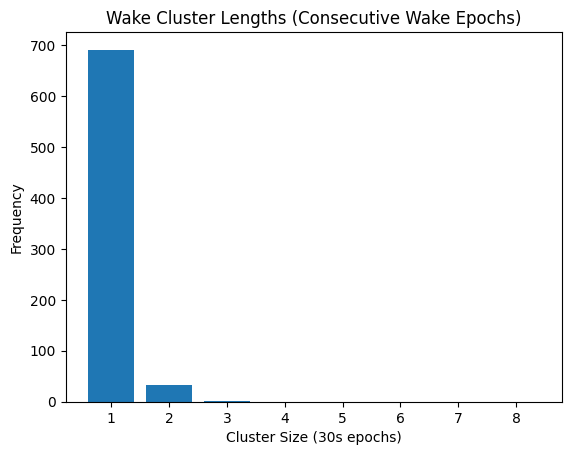

In [ ]:
from itertools import groupby

consecutive_rem_lengths = []
count = 0

for label, group in groupby(y):
    g = list(group)
    if label == 'Wake':
        consecutive_rem_lengths.append(len(g))

import matplotlib.pyplot as plt
plt.hist(consecutive_rem_lengths, bins=range(1,10), align='left', rwidth=0.8)
plt.title("Wake Cluster Lengths (Consecutive Wake Epochs)")
plt.xlabel("Cluster Size (30s epochs)")
plt.ylabel("Frequency")
plt.show()
